# LOB-Bench Tutorial Notebook

For detailed documentation, please see the README file. 
We start by importing the required modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import urllib.request
url = 'https://drive.google.com/uc?id=1b5FskJykGbWvVwKd7YhzRwEf0YIcmOR9&export=downloads'
filename = 'test.zip'
urllib.request.urlretrieve(url, filename)

('test.zip', <http.client.HTTPMessage at 0x7fcef872a560>)

In [3]:
import zipfile
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [5]:
#3rd Party Packages
import numpy as np
import pandas as pd
import jax.numpy as jnp
import glob

#Lob-Bench Modules
import data_loading
import eval
import partitioning
import impact
import plotting
import metrics
import scoring
import matplotlib.pyplot as plt


/tmp/ipykernel_2800706/4254918306.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Dataloader
THe dataloader requires only the file-paths to the generated csv files containing sequences of LOBSTER-style message and orderbook data.
See https://lobsterdata.com/info/DataStructure.php for documentation on the format of these files. \
The 'cond' folder is for the sequences used to pre-condition the generative model (if applicable). \
The 'gen' folder is for generated sequences. \
The 'real' folder is for historical sequences to which one may compare the generated sequences (typically those which follow te cond sequence). 

In [6]:
stock = 'GOOG'
model='notebook_sample'
# loader = data_loading.Simple_Loader(real_data_path='/data1/sascha/data/generated_data/GOOG/data_real_small',
#                                     gen_data_path='/data1/sascha/data/generated_data/GOOG/data_gen_small',
#                                     cond_data_path='/data1/sascha/data/generated_data/GOOG/data_cond_small')
loader = data_loading.Simple_Loader(real_data_path='data/data_saved/large_model_sample/GOOG/data_real',
                                    gen_data_path='data/data_saved/large_model_sample/GOOG/data_gen',
                                    cond_data_path='data/data_saved/large_model_sample/GOOG/data_cond')
for s in loader:
    s.materialize()

In [10]:
len(loader)

0

### Scoring Dictionary

The scoring dictionary can contain any functions which return a one dimensional vector based on a sequence of messages and orderbook states.\
It may also contain scores conditional on other score functions. 

In [7]:
scoring_config_dict = {
    "spread": {
        "fn": lambda m, b: eval.spread(m, b).values,#.mean(),
        "discrete": True,
    },
    "orderbook_imbalance": {
        "fn": lambda m, b: eval.orderbook_imbalance(m, b).values,
    },
    
    # TIMES (log scale)
    "log_inter_arrival_time": {
        # "fn": lambda m, b: eval.inter_arrival_time(m).values.astype(float),
        "fn": lambda m, b: np.log(eval.inter_arrival_time(m).replace({0: 1e-9}).values.astype(float)),
    },
    "log_time_to_cancel": {
        # "fn": lambda m, b: eval.time_to_cancel(m).values.astype(float),
        "fn": lambda m, b: np.log(eval.time_to_cancel(m).replace({0: 1e-9}).values.astype(float)),
    },
    
    # VOLUMES:
    "ask_volume_touch": {
        "fn": lambda m, b: eval.l1_volume(m, b).ask_vol.values,
    },
    "bid_volume_touch": {
        "fn": lambda m, b: eval.l1_volume(m, b).bid_vol.values,
    },
    "ask_volume": {
        "fn": lambda m, b: eval.total_volume(m, b, 10).ask_vol_10.values,
    },
    "bid_volume": {
        "fn": lambda m, b: eval.total_volume(m, b, 10).bid_vol_10.values,
    },

    # DEPTHS:
    "limit_ask_order_depth": {
        "fn": lambda m, b: eval.limit_order_depth(m, b)[0].values,
    },
    "limit_bid_order_depth": {
        "fn": lambda m, b: eval.limit_order_depth(m, b)[1].values,
    },
    "ask_cancellation_depth": {
        "fn": lambda m, b: eval.cancellation_depth(m, b)[0].values,
    },
    "bid_cancellation_depth": {
        "fn": lambda m, b: eval.cancellation_depth(m, b)[1].values,
    },

    # LEVELS:
    "limit_ask_order_levels": {
        "fn": lambda m, b: eval.limit_order_levels(m, b)[0].values,
        "discrete": True,
    },
    "limit_bid_order_levels": {
        "fn": lambda m, b: eval.limit_order_levels(m, b)[1].values,
        "discrete": True,
    },
    "ask_cancellation_levels": {
        "fn": lambda m, b: eval.cancel_order_levels(m, b)[0].values,
        "discrete": True,
    },
    "bid_cancellation_levels": {
        "fn": lambda m, b: eval.cancel_order_levels(m, b)[1].values,
        "discrete": True,
    },
}

scoring_config_dict_cond = {
    ######################## CONDITIONAL SCORING ########################
    "ask_volume | spread": {
        "eval": {
            "fn": lambda m, b: eval.l1_volume(m, b).ask_vol.values,
        },
        "cond": {
            "fn": lambda m, b: eval.spread(m, b).values,
            "discrete": True,
        }
    },
    "spread | time": {
        "eval": {
            "fn": lambda m, b: eval.spread(m, b).values,
        },
        "cond": {
            "fn": lambda m, b: eval.time_of_day(m).values,
            # group by hour of the day (start of sequence)
            "thresholds": np.linspace(0, 24*60*60, 24),
        }
    },
    "spread | volatility": {
        "eval": {
            "fn": lambda m, b: eval.spread(m, b).values,
            "discrete": True,
        },
        "cond": {
            "fn": lambda m, b: [eval.volatility(m,b,'0.1s')] * len(m),
        }
    }
}

### Metrics

The metric functions are a measure of distance between the distributions of the score function for the real and generated data. 

In [8]:
metrics_fns_dict={'l1': metrics.l1_by_group,
                    'wasserstein': metrics.wasserstein,
                    }

### Running the benchmark
The benchmark evaluates all the score functions and returns the results which are described below. 

In [9]:
scores, score_dfs, plot_fns = scoring.run_benchmark(
    loader,
    scoring_config_dict,
    default_metric=metrics_fns_dict
)

ValueError: need at least one array to concatenate

The 1st returned argument is a dictionary containing the distances between distributions for each of the score provided, for each of the metrics provided.
An example for the L1 distance for the spread is given below. The second and third elements are the bootstrapped confidence intervals and the samples used for bootstrapping. \
The summary_stats function can be used to aggregate the metrics across all score functions. 

In [57]:
score_dfs.keys()

dict_keys(['spread', 'orderbook_imbalance', 'log_inter_arrival_time', 'log_time_to_cancel', 'ask_volume_touch', 'bid_volume_touch', 'ask_volume', 'bid_volume', 'limit_ask_order_depth', 'limit_bid_order_depth', 'ask_cancellation_depth', 'bid_cancellation_depth', 'limit_ask_order_levels', 'limit_bid_order_levels', 'ask_cancellation_levels', 'bid_cancellation_levels'])

In [68]:

scores['ask_volume_touch']['wasserstein']

(0.23809886674304737,
 array([0.2340581 , 0.24330307]),
 array([0.23809887, 0.23613734, 0.23595336, 0.23803198, 0.24155927,
        0.23678285, 0.2364936 , 0.23669589, 0.23858465, 0.23361876,
        0.23747215, 0.24220903, 0.23908443, 0.23480513, 0.2376549 ,
        0.23781653, 0.24366402, 0.23637731, 0.23563062, 0.23610095,
        0.23629634, 0.23754705, 0.24175658, 0.23681675, 0.23940558,
        0.23487098, 0.23789264, 0.23665358, 0.23626078, 0.23953165,
        0.23955358, 0.23573194, 0.23715958, 0.23733319, 0.23961175,
        0.23724961, 0.23857666, 0.2381862 , 0.23825734, 0.23804242,
        0.23953246, 0.23874955, 0.2414714 , 0.23809681, 0.2415802 ,
        0.23622129, 0.2400013 , 0.23747781, 0.23891541, 0.23908396,
        0.23605159, 0.23902953, 0.23923269, 0.23676474, 0.24008608,
        0.23740602, 0.23766988, 0.24069429, 0.24008283, 0.23694533,
        0.2359651 , 0.23749428, 0.23724578, 0.24011229, 0.24294212,
        0.23695576, 0.2380414 , 0.23898033, 0.23765308, 0.24

In [70]:
summary_stats=scoring.summary_stats(scores, bootstrap=True)
summary_stats['wasserstein']


((0.3002933249637061, array([0.29790768, 0.30279165])),
 (0.25542558565817153, array([0.24922345, 0.26299194])),
 (array(0.264611), array([0.26141708, 0.26861281])))

In [81]:
##Run only if wasserstein gives error
if model=='toastypine':
    del scores['log_inter_arrival_time']
    del scores['log_time_to_cancel']

    del score_dfs['log_inter_arrival_time']
    del score_dfs['log_time_to_cancel']

    del plot_fns['log_inter_arrival_time']
    del plot_fns['log_time_to_cancel']


The below code prints a visual version of these summary statistics.

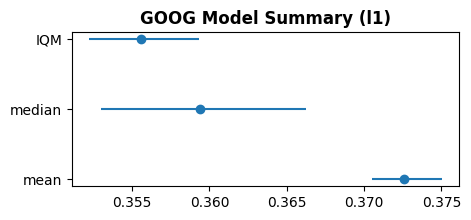

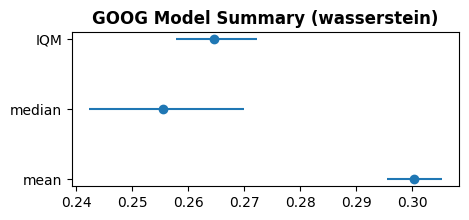

In [71]:
for loss_metric in summary_stats.keys():

    scatter_vals = summary_stats[loss_metric]
    scatter_x = [val[0] for val in scatter_vals]
    cis = np.array([val[1] for val in scatter_vals])

    plt.figure(figsize=(5,2))
    plt.scatter(scatter_x, ['mean', 'median', 'IQM'])
    # add errorbars
    plt.errorbar(
        x=cis.mean(axis=1),
        y=['mean', 'median', 'IQM'],
        xerr=np.diff(cis, axis=1).T[0],
        fmt='none'
    )
    plt.title(f"{stock} Model Summary ({loss_metric})", fontweight='bold')
    plt.savefig(f'images/summary_stats_{loss_metric}_{stock}_{model}.png', dpi=300, bbox_inches='tight')

The second returned argument is the dictionary of pandas data-frames containing the raw values for the scoring function for each of the entries in each of the sequences, both real and generated. \
The 'group' value indicates the bucket in which this entry is allocated for the distribution histogram. \
Below is an example for the 'spread' score. 

In [37]:
score_dfs['spread']


,score,group,type
0,700,7,real
1,700,7,real
2,700,7,real
3,700,7,real
4,700,7,real
...,...,...,...
269851,100,1,generated
269852,100,1,generated
269853,100,1,generated
269854,100,1,generated


### Visualising results

Finally, the dictionary of plot functions returned allows for very easy plotting of the histogram for a given score type. Careful! The plot functions for conditional scores do not take the name and ax arguments. 

plotting.py: n_Bins to use in histogram 7


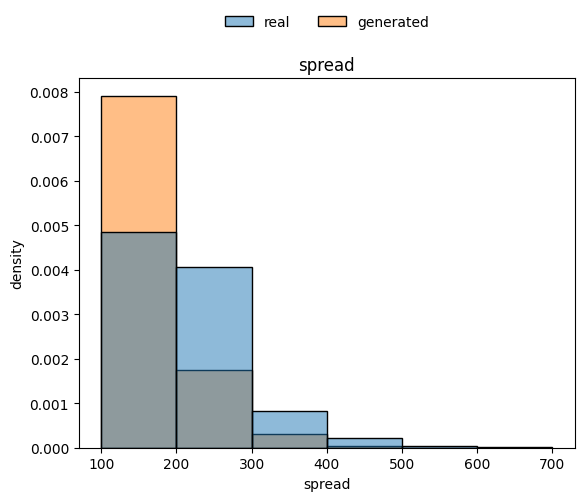

In [33]:
fig,ax=plt.subplots()
name='spread'
# fn()
plot_fns[name](name,ax)
fig.show()

### Visualisation of losses : Wasserstein
The following two code cells generate and save a visualisation of the losses for each of the scores using the Wasserstein metric as well as the bootstrapped confidence intervals. 

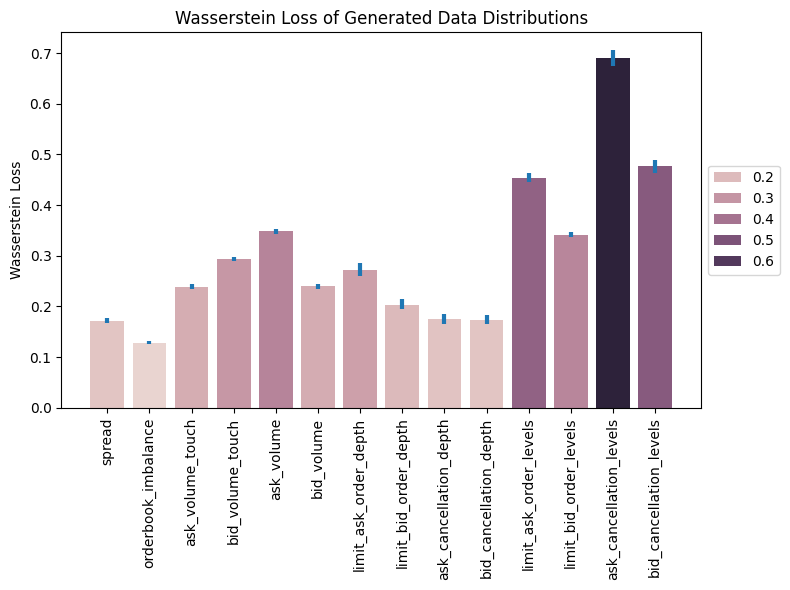

In [72]:
# Wasserstein Loss

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['wasserstein'][0]for s in scores.values()])
cis = np.array([s['wasserstein'][1]for s in scores.values()]).T

plt.figure(figsize=(8,6))
b = sns.barplot(
    x=labels,
    y=losses,
    hue=losses,
    legend='brief'
    # palette=np.array(pal[::-1])[rank]
)
plt.errorbar( # ([0.01]*len(labels), [0.03]*len(labels))
    x=labels, y=cis.mean(axis=0), yerr=np.diff(cis, axis=0)/2,
    fmt='none', elinewidth=3)
_ = plt.xticks(rotation=90)

plt.title('Wasserstein Loss of Generated Data Distributions')
plt.ylabel('Wasserstein Loss')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# save fig as png
plt.savefig(f'images/bar_plot_comparison_wasserstein_{stock}_{model}.png')

In [73]:
import plotly.graph_objects as go

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['wasserstein'][0]for s in scores.values()])
cis = np.array([s['wasserstein'][1]for s in scores.values()]).T

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=-losses,
    theta=labels,
    mode='lines',
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',  # Set opacity to 0.5
    name='CI upper',
    line=dict(color='rgba(31, 119, 180, 1)'),
))
fig.add_trace(go.Scatterpolar(
    r=-cis[0],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    name='CI lower',
    line=dict(color='rgba(31, 119, 180, 0.2)', width=0),
    # fill='tonext',
))
fig.add_trace(go.Scatterpolar(
    r=-cis[1],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    fill='tonext',
    fillcolor='rgba(31, 119, 180, 0.5)',
    name='CI upper',
    line=dict(color='rgb(31, 119, 180)', width=0),
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-0.8, 0]
    )),
  showlegend=False,
  title='Wasserstein Distances',
  margin=dict(l=20, r=20, t=40, b=40),
)

fig.write_image(f"images/wasserstein_comparison_{stock}_{model}.png")
fig.show()


### Visualisation of losses : L1 Loss
The following two code cells generate and save a visualisation of the losses for each of the scores using the L1 Loss metric as well as the bootstrapped confidence intervals. 

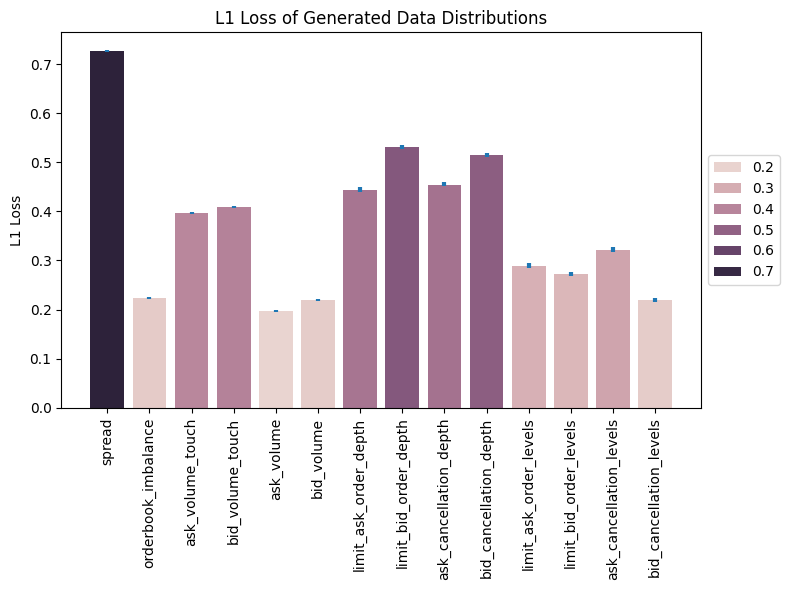

In [74]:
# L1 Loss

import matplotlib.pyplot as plt
import seaborn as sns

labels = list(scores.keys())
# pal = sns.color_palette("rocket", len(scores))
losses = np.array([s['l1'][0]for s in scores.values()])
cis = np.array([s['l1'][1]for s in scores.values()]).T

plt.figure(figsize=(8,6))
b = sns.barplot(
    x=labels,
    y=losses,
    hue=losses,
    legend='brief'
    # palette=np.array(pal[::-1])[rank]
)
plt.errorbar( # ([0.01]*len(labels), [0.03]*len(labels))
    x=labels, y=cis.mean(axis=0), yerr=np.diff(cis, axis=0)/2,
    fmt='none', elinewidth=3)
_ = plt.xticks(rotation=90)

plt.title('L1 Loss of Generated Data Distributions')
plt.ylabel('L1 Loss')

plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

# save fig as png
plt.savefig(f'images/bar_plot_comparison_l1_{stock}_{model}.png')

In [77]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=1-losses,
    theta=labels,
    mode='lines',
    fill='toself',
    fillcolor='rgba(31, 119, 180, 0.2)',  # Set opacity to 0.5
    name='CI upper',
    line=dict(color='rgba(31, 119, 180, 1)'),
))
fig.add_trace(go.Scatterpolar(
    r=1-cis[0],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    name='CI lower',
    line=dict(color='rgba(31, 119, 180, 0.2)', width=0),
    # fill='tonext',
))
fig.add_trace(go.Scatterpolar(
    r=1-cis[1],
    theta=labels,
    mode='lines',  # Add this line to remove markers
    fill='tonext',
    fillcolor='rgba(31, 119, 180, 0.5)',
    name='CI upper',
    line=dict(color='rgb(31, 119, 180)', width=0),
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0.1, 1]
    )),
  showlegend=False,
  title='L1 Scores',
  margin=dict(l=20, r=20, t=40, b=40),
)

fig.write_image(f"images/l1_comparison_{stock}_{model}.png")
fig.show()


### Histograms of score functions
As evidenced with an example previously, the histograms can be given for all of the score functions showing the difference between real and generated data. 

In [ ]:
# Plot all histograms in single subplot
# plotting.hist_subplots(plot_fns, (10, 25))

spread
plotting.py: n_Bins to use in histogram 463
orderbook_imbalance
plotting.py: n_Bins to use in histogram 79
ask_volume_touch
plotting.py: n_Bins to use in histogram 43876
bid_volume_touch
plotting.py: n_Bins to use in histogram 10903
ask_volume
plotting.py: n_Bins to use in histogram 11497
bid_volume
plotting.py: n_Bins to use in histogram 22795
limit_ask_order_depth
plotting.py: n_Bins to use in histogram 36054
limit_bid_order_depth
plotting.py: n_Bins to use in histogram 5445
ask_cancellation_depth
plotting.py: n_Bins to use in histogram 36642
bid_cancellation_depth
plotting.py: n_Bins to use in histogram 5686
limit_ask_order_levels
plotting.py: n_Bins to use in histogram 20
limit_bid_order_levels
plotting.py: n_Bins to use in histogram 20
ask_cancellation_levels
plotting.py: n_Bins to use in histogram 20
bid_cancellation_levels
plotting.py: n_Bins to use in histogram 20


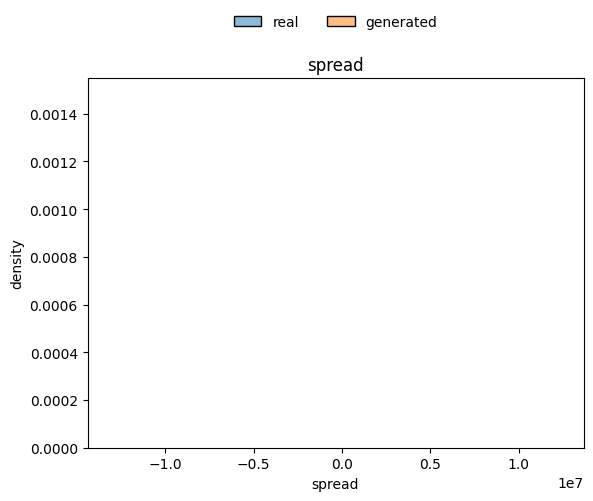

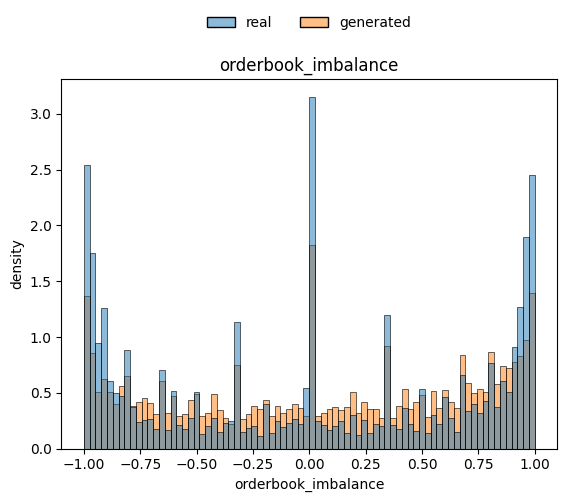

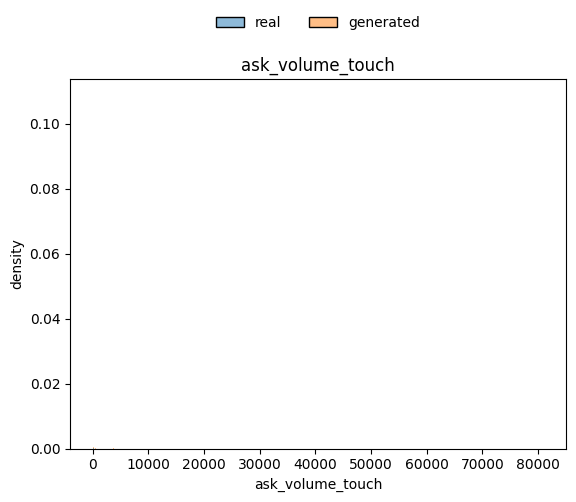

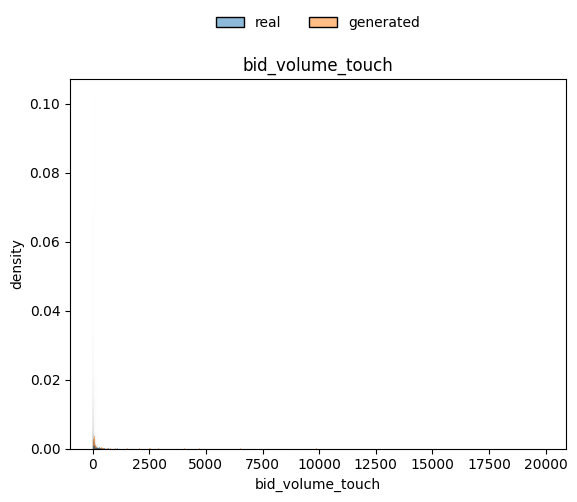

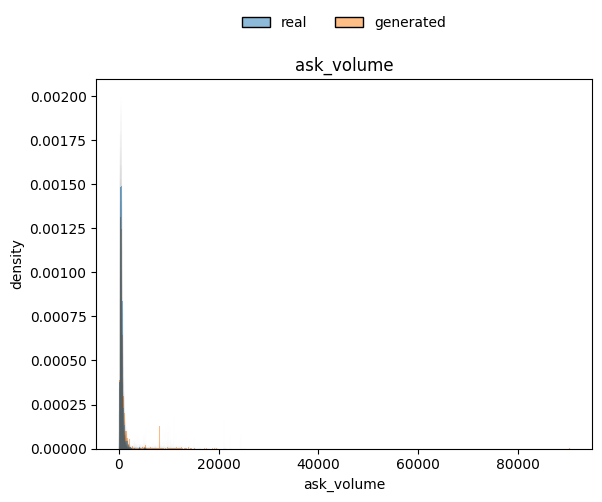

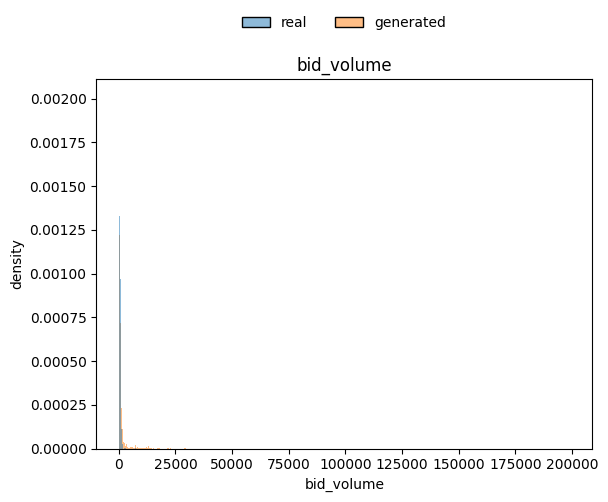

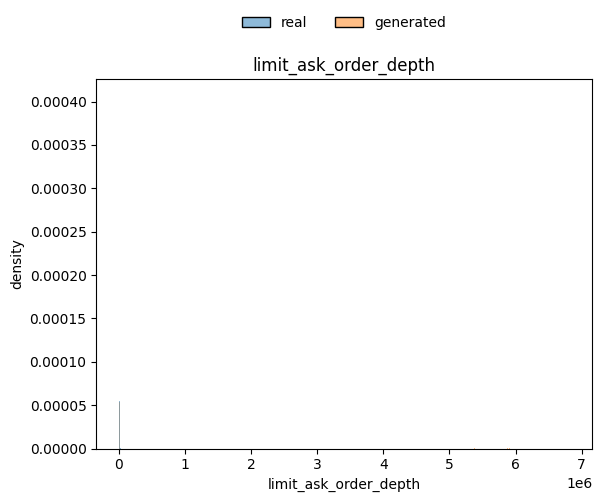

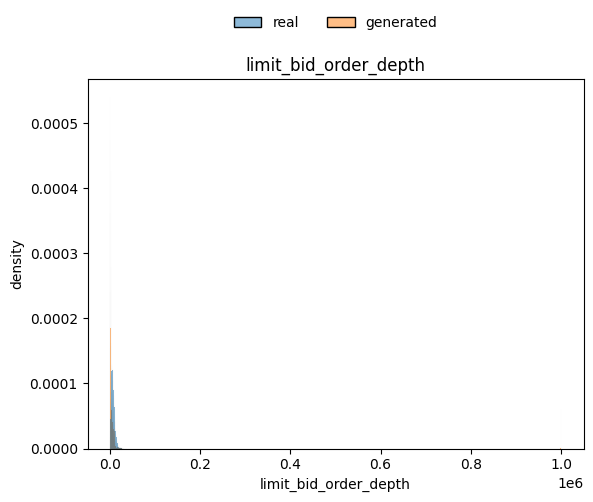

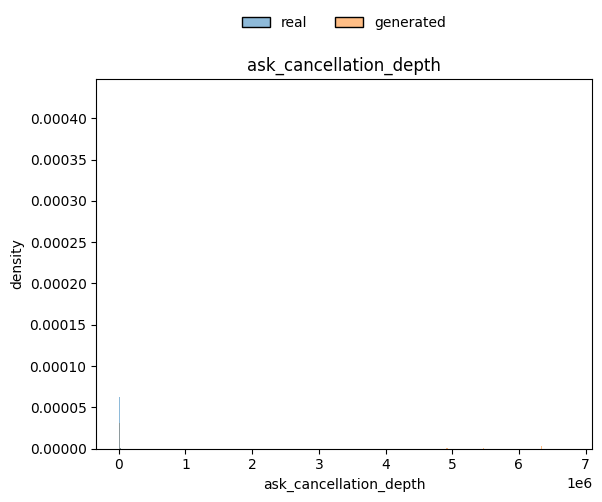

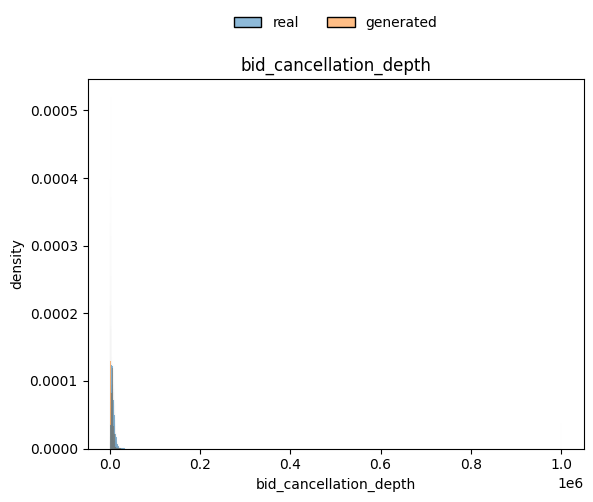

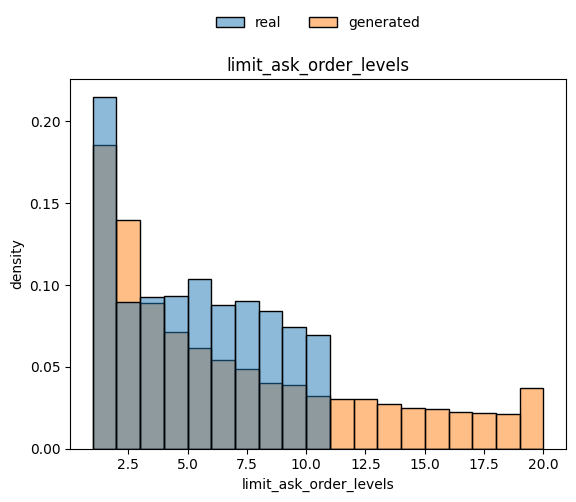

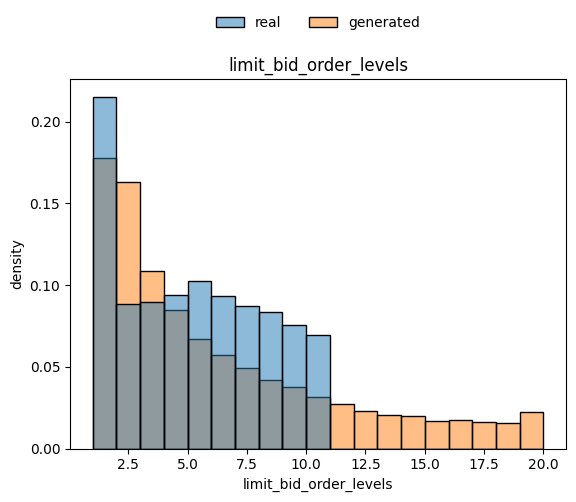

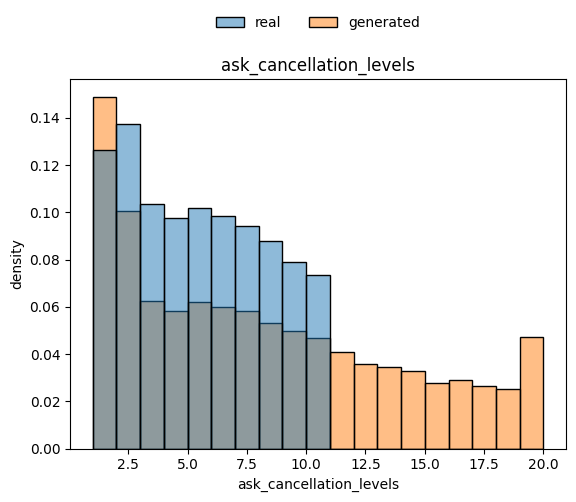

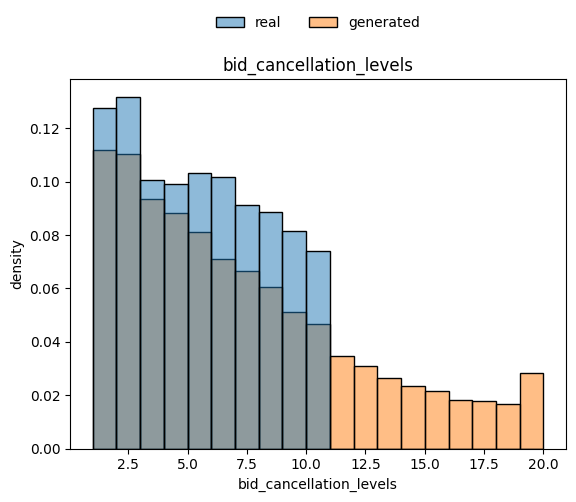

In [82]:
# HISTOGRAMS
for name, fn in plot_fns.items():
    print(name)
    fig,ax=plt.subplots()
    fn(name,ax)
    fig.show()

plotting.py: n_Bins to use in histogram 463
plotting.py: n_Bins to use in histogram 79
plotting.py: n_Bins to use in histogram 43876
plotting.py: n_Bins to use in histogram 10903
plotting.py: n_Bins to use in histogram 11497
plotting.py: n_Bins to use in histogram 22795
plotting.py: n_Bins to use in histogram 36054
plotting.py: n_Bins to use in histogram 5445
plotting.py: n_Bins to use in histogram 36642
plotting.py: n_Bins to use in histogram 5686
plotting.py: n_Bins to use in histogram 20
plotting.py: n_Bins to use in histogram 20
plotting.py: n_Bins to use in histogram 20
plotting.py: n_Bins to use in histogram 20


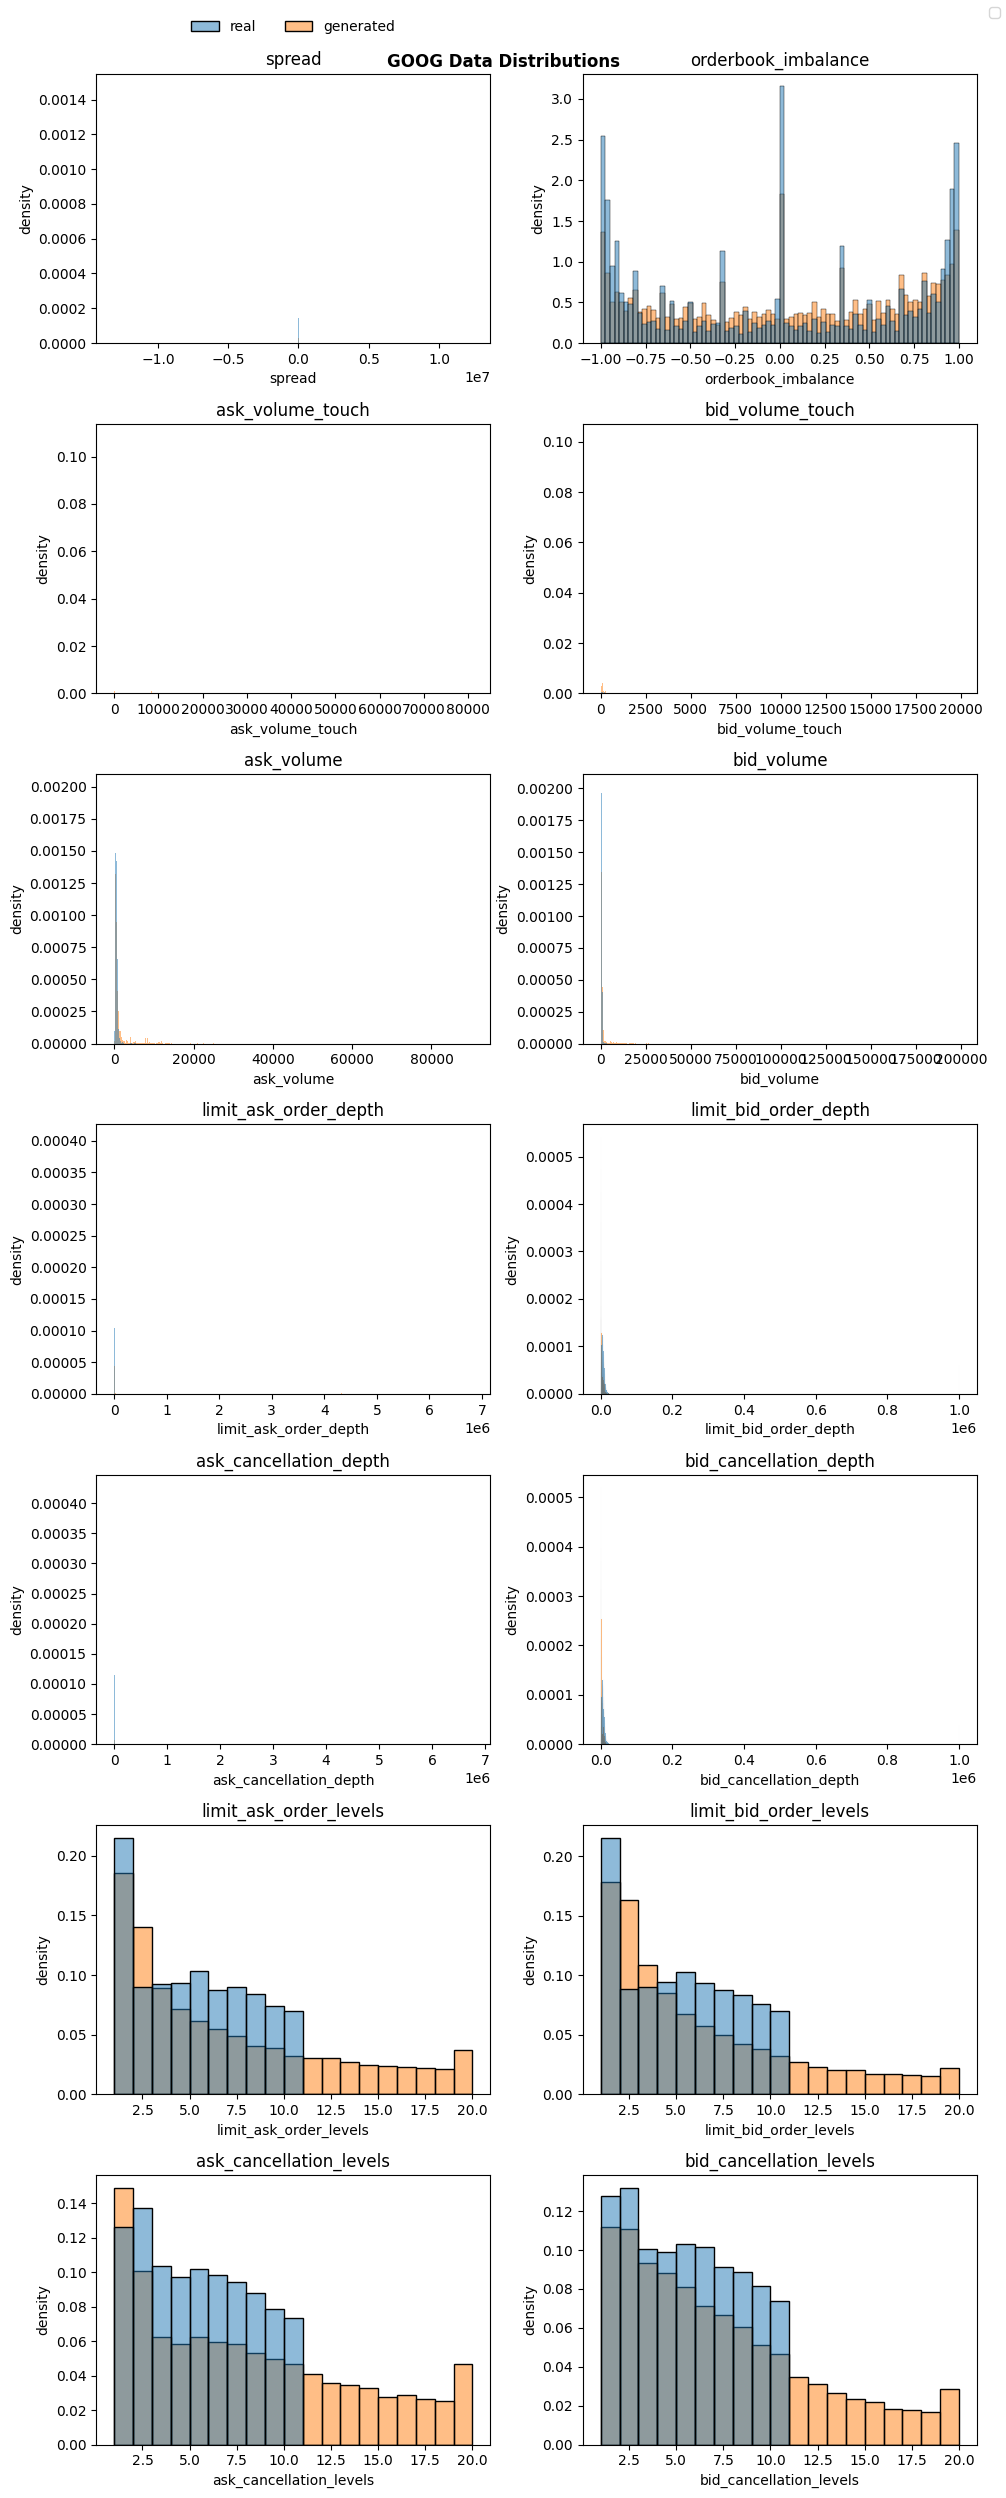

In [83]:
# Plot all histograms in single subplot
plotting.hist_subplots(plot_fns, (10, 25))
plt.suptitle(f'{stock} Data Distributions', fontweight='bold')
plt.savefig(f'images/hist_subplots_{stock}_{model}.png', dpi=300, bbox_inches='tight')

### Evaluate divergence of distributions - Long range dependencies
By setting the 'divergence' argument in the run_benchmark function, it is possible to generate plot functions that show the evolution of the difference in distributions throughout a sequence of messages, thereby investigating the long-range divergence. 

In [84]:
scores_, score_dfs_, plot_fns_ = scoring.run_benchmark(
    loader, scoring_config_dict, metrics.l1_by_group,
    divergence=True)

/tmp/ipykernel_1619283/4279360297.py:13: RuntimeWarning:

invalid value encountered in log



In [86]:
##Run only if wasserstein gives error
if model=='toastypine':
    del scores_['log_inter_arrival_time']
    del scores_['log_time_to_cancel']

    del score_dfs_['log_inter_arrival_time']
    del score_dfs_['log_time_to_cancel']

    del plot_fns_['log_inter_arrival_time']
    del plot_fns_['log_time_to_cancel']


spread
orderbook_imbalance
log_inter_arrival_time
log_time_to_cancel
ask_volume_touch
bid_volume_touch
ask_volume
bid_volume
limit_ask_order_depth
limit_bid_order_depth
ask_cancellation_depth
bid_cancellation_depth
limit_ask_order_levels
limit_bid_order_levels
ask_cancellation_levels
bid_cancellation_levels


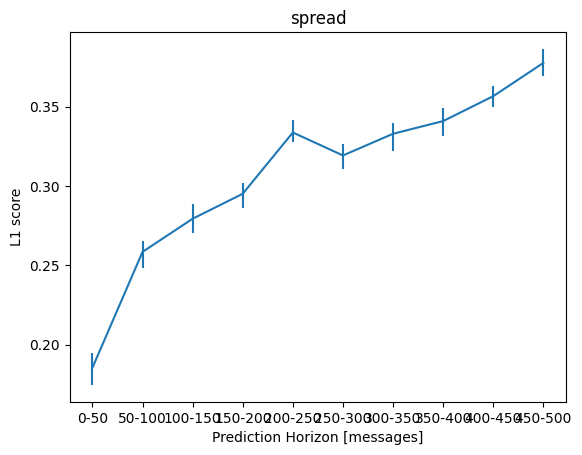

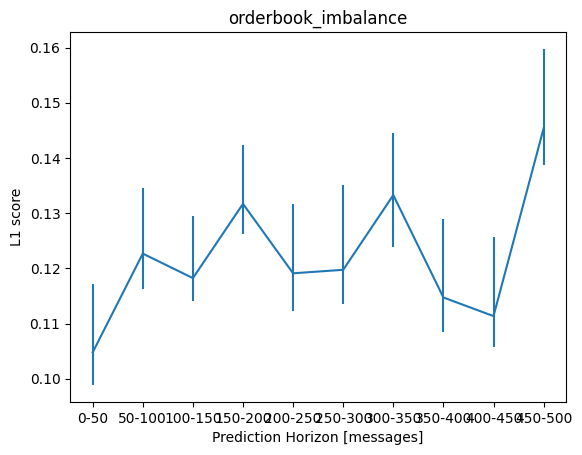

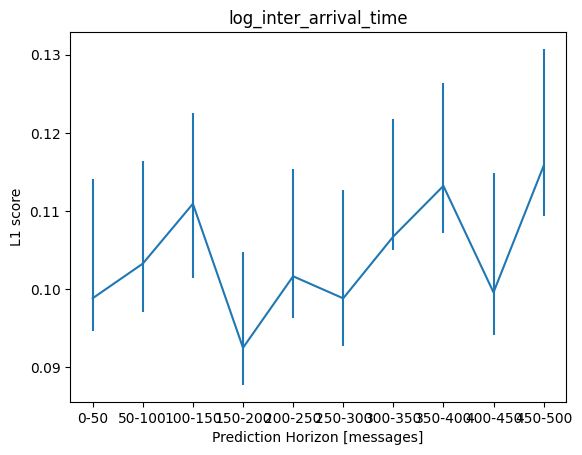

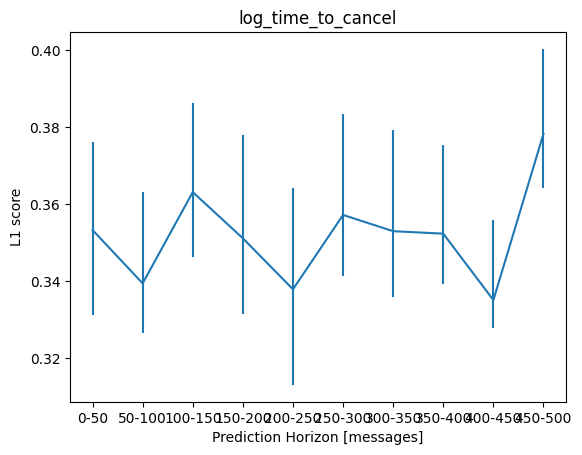

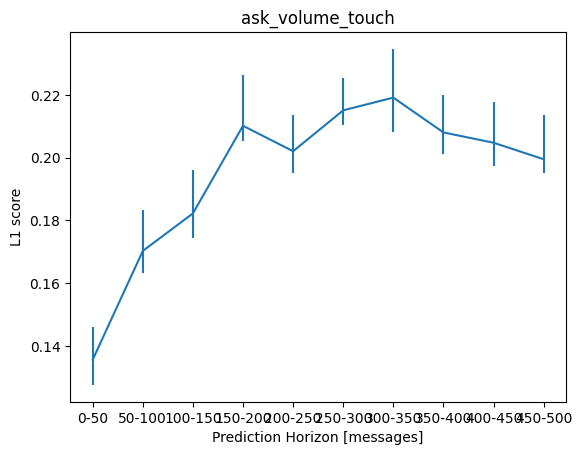

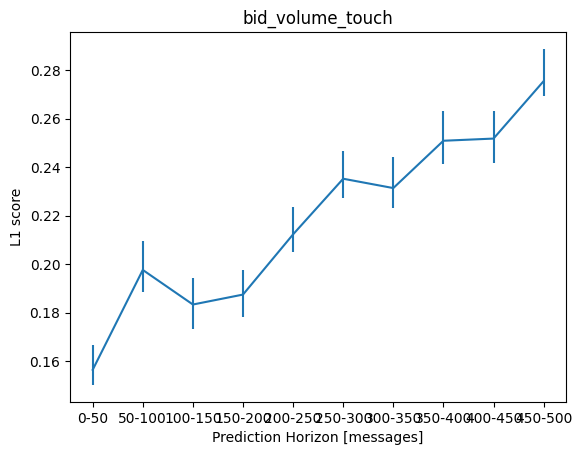

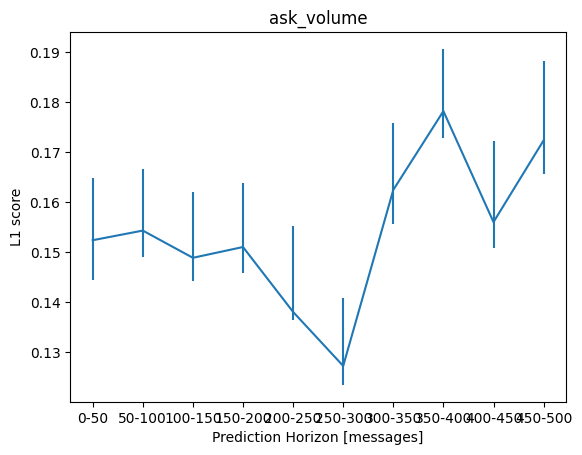

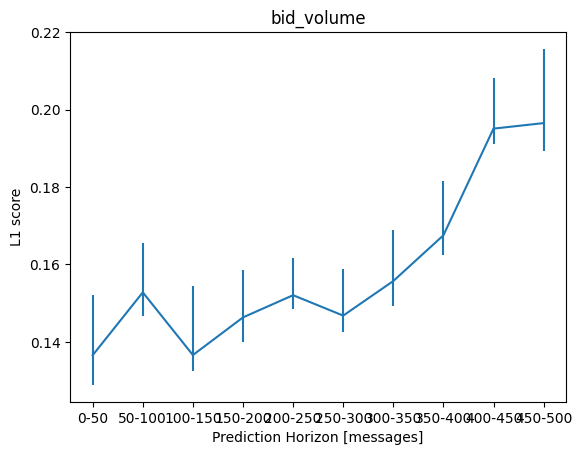

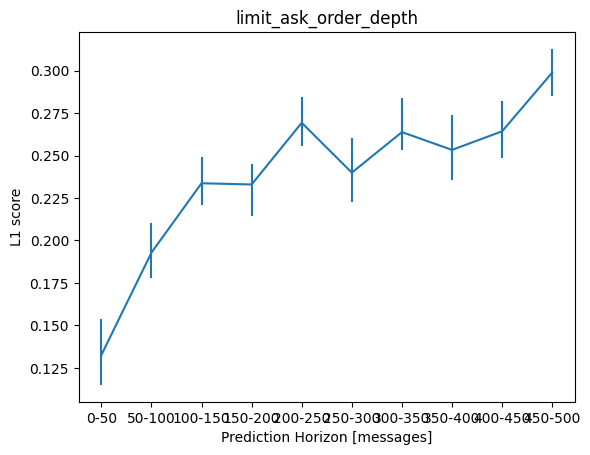

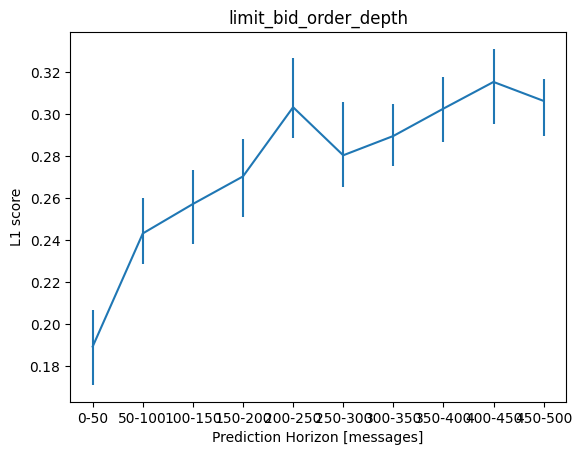

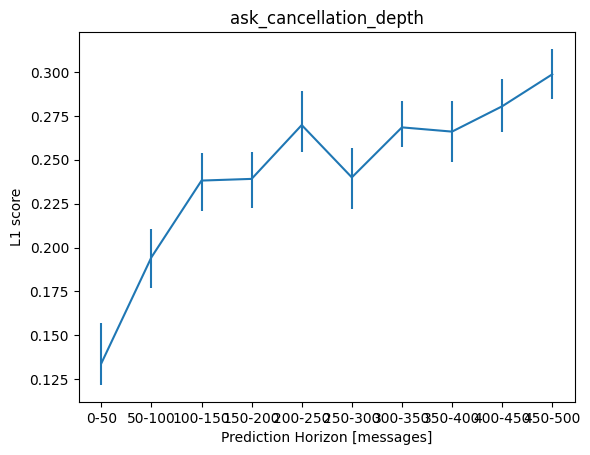

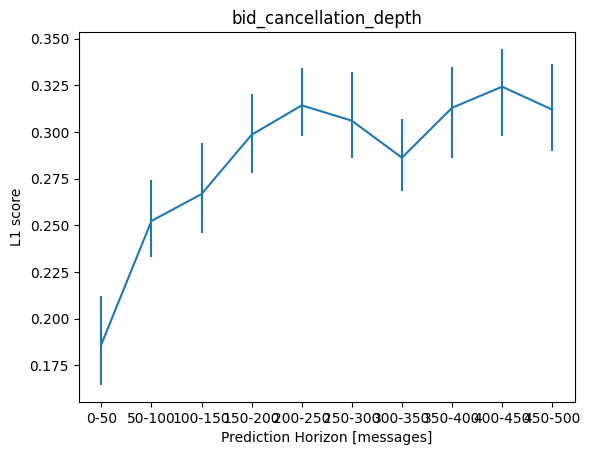

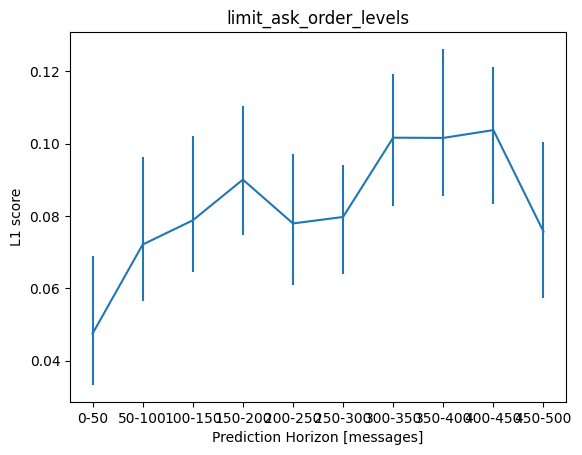

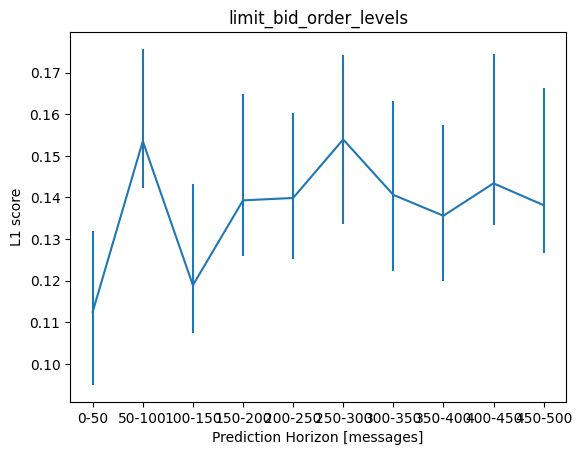

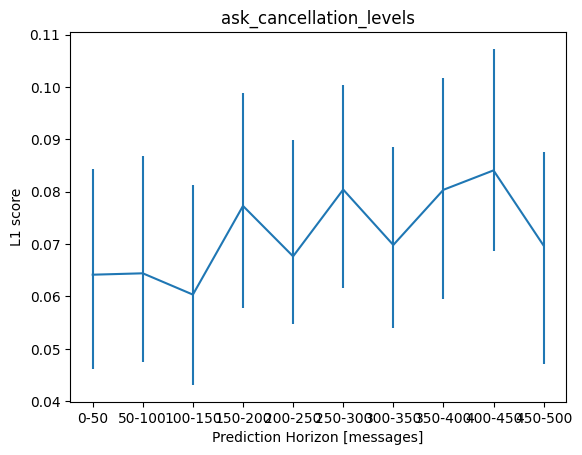

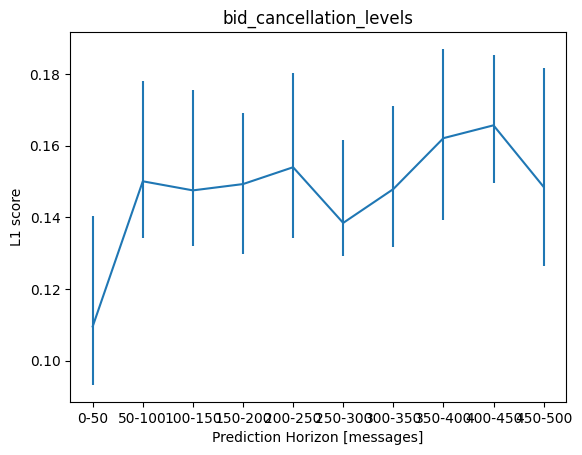

In [51]:
for name, fn in plot_fns_.items():
    print(name)
    fig,ax=plt.subplots()
    fn(name,ax)
    fig.show()


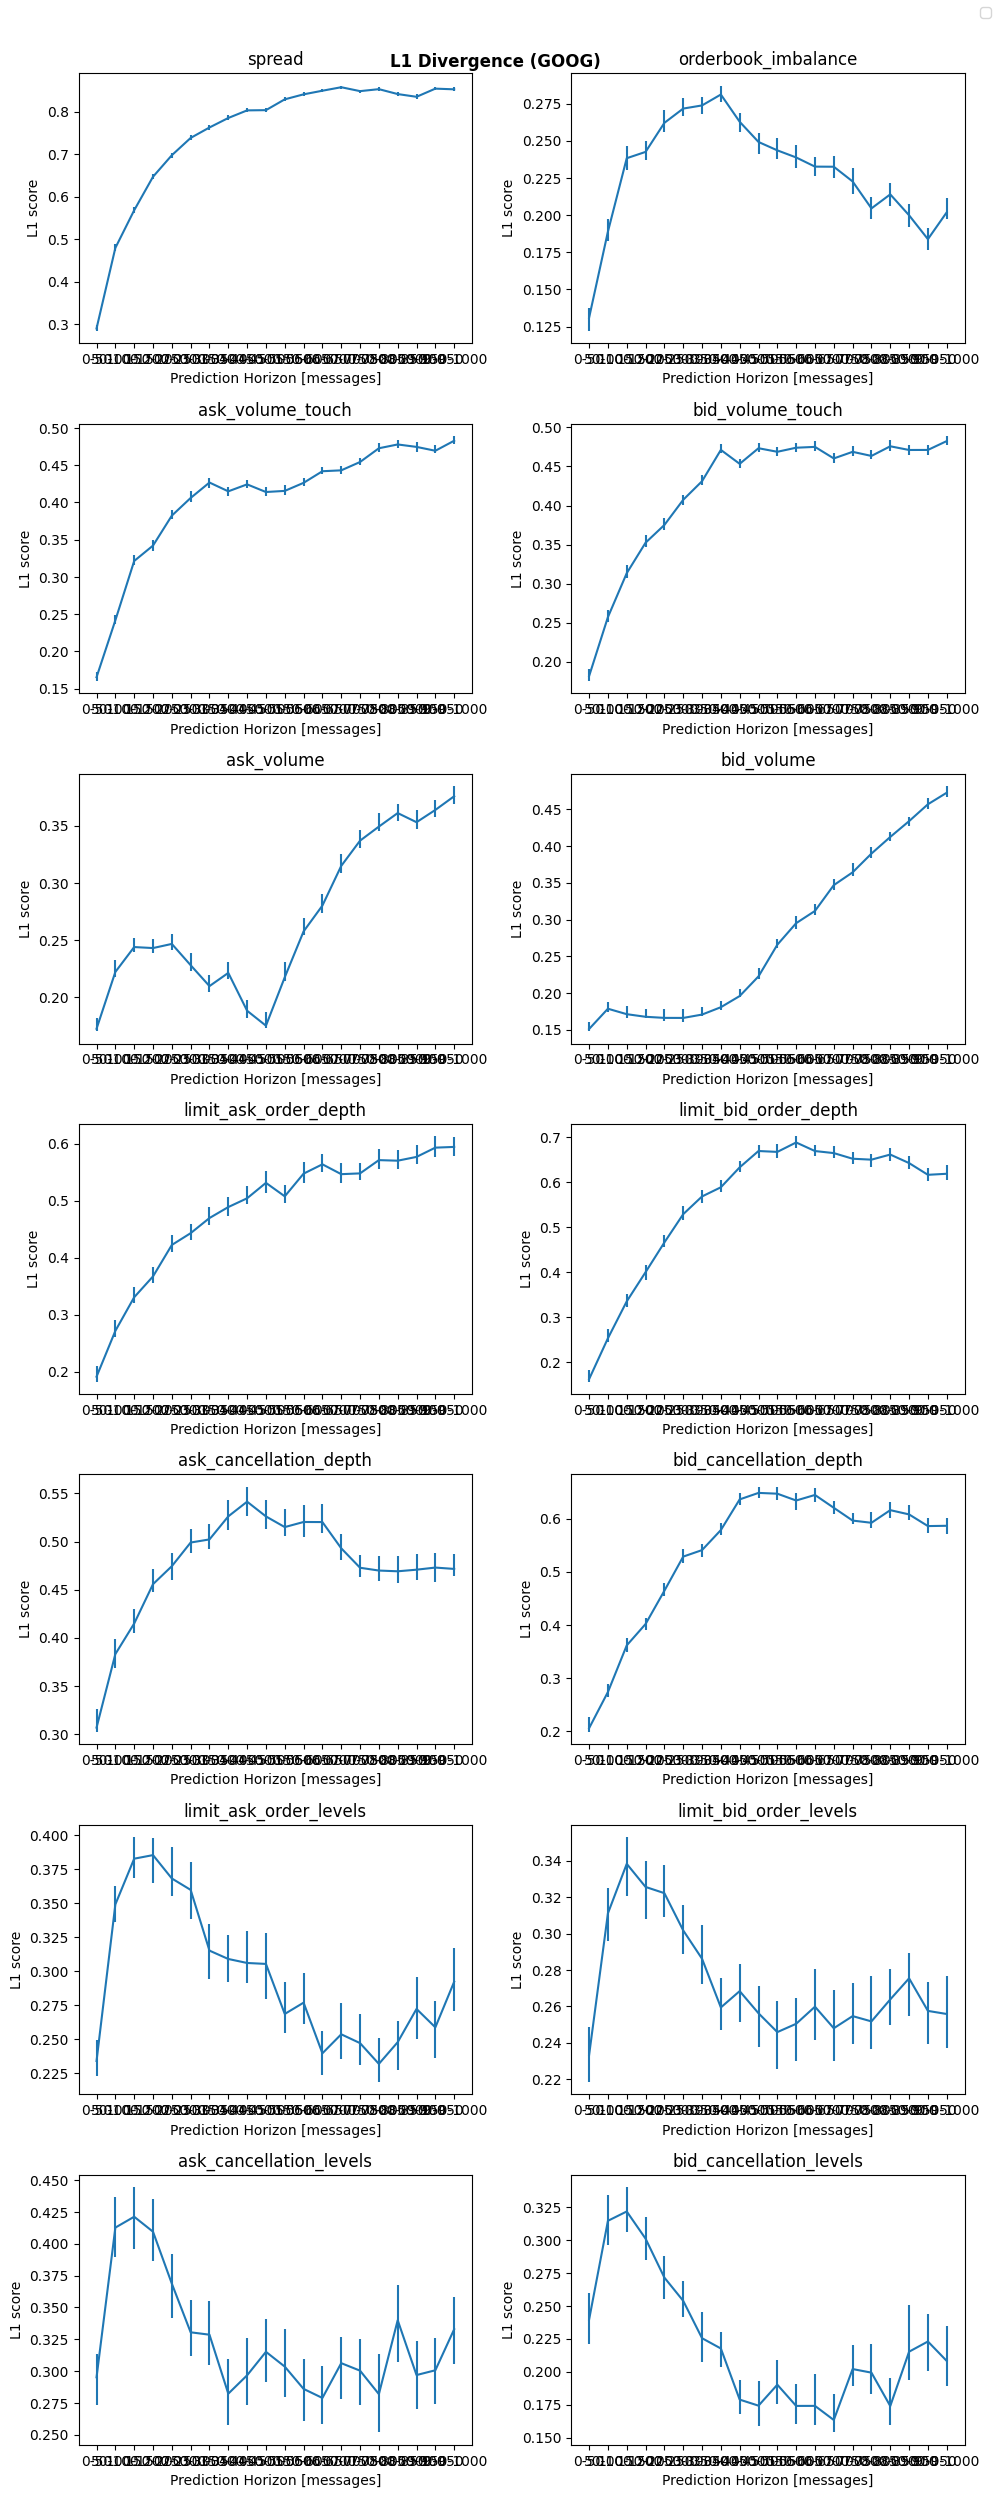

In [87]:
plotting.hist_subplots(plot_fns_, (10, 25))
plt.suptitle(f'L1 Divergence ({stock})', fontweight='bold')
plt.tight_layout()
plt.savefig(f'images/metric_divergence_{stock}_{model}.png', dpi=300, bbox_inches='tight')

### Impact response functions

By passing the loader to the impact_compare function, the response curves are automatically calculated and plotted, saving the figures to the working directory. \
Further, the sum of absolute differences (L1) is calculated between the response curves of the real and generated data sequences.

Calculating for event type:  MO_0
Calculating for event type:  MO_1
Calculating for event type:  LO_0
Calculating for event type:  LO_1
Calculating for event type:  CA_0
Calculating for event type:  CA_1
Sum of abs differences for  MO_0  events: 1009262.9865662633
Sum of abs differences for  MO_1  events: 6283806.046529795
Sum of abs differences for  LO_0  events: 8372633.008188972
Sum of abs differences for  LO_1  events: 12140243.654846547
Sum of abs differences for  CA_0  events: 16038407.514364365
Sum of abs differences for  CA_1  events: 23713083.030425996


11259572.706820324

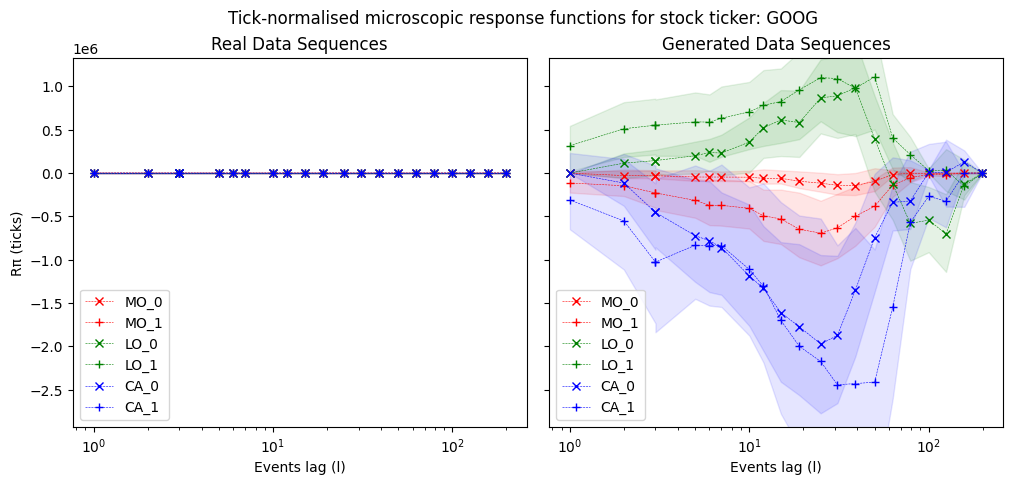

In [88]:
impact.impact_compare(loader,ticker=stock,model=model)

### Discriminator

SyntaxError: invalid syntax (563418963.py, line 1)